Threshold Value: 146
Particle Coverage: 51.77%


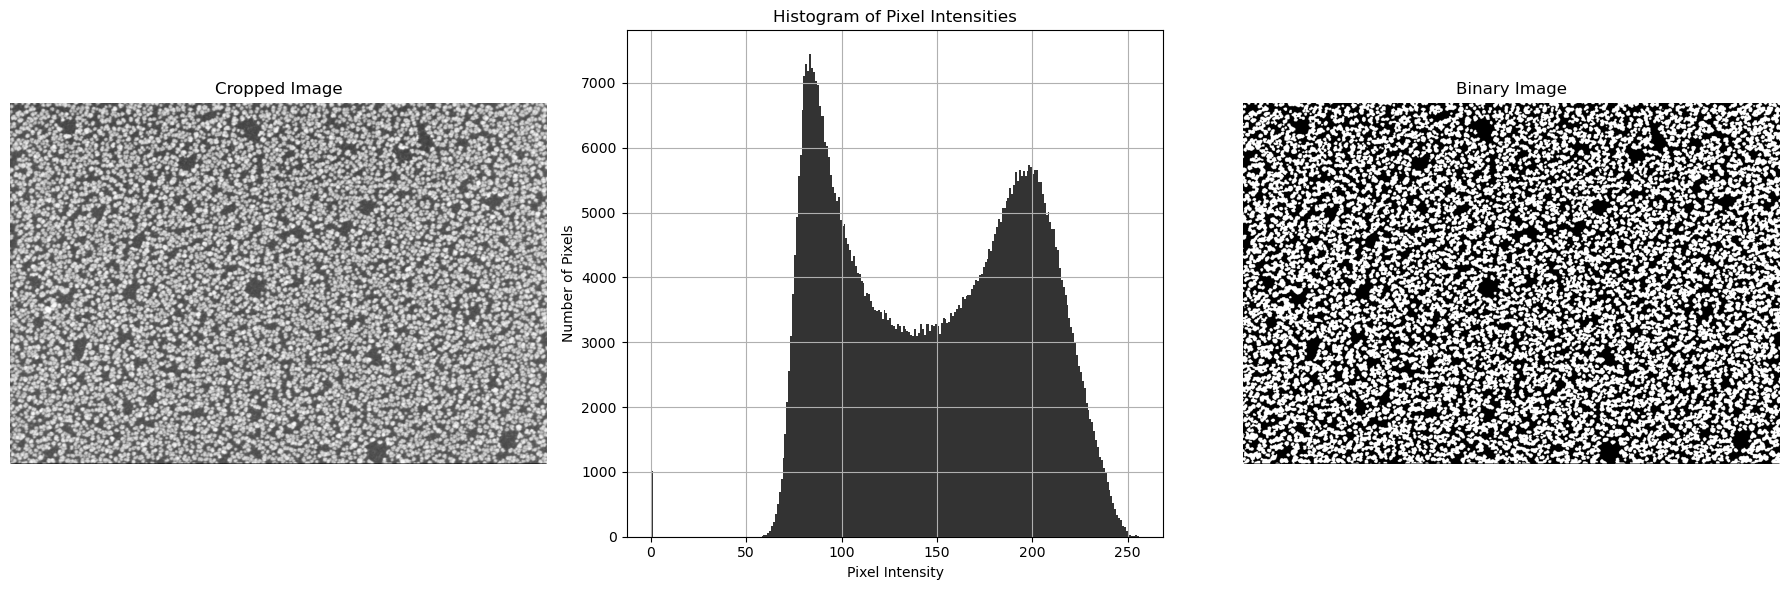

Binary image saved as: binary_image_cropped.tif


In [5]:
##To visualize the histograms and binary images
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.filters import threshold_otsu

# Load the TIF file using tifffile
file_path = '/Users/divyansh/Documents/PhD/4th Semester/Plotting data/Performace extracter/Data Structure/LED-DG024/LED-DG024-Images/LED-DG024S1_02.tif'
image = tiff.imread(file_path)

# Ensure the image is in grayscale
if len(image.shape) > 2:
    image = np.mean(image, axis=2)

# Define crop coordinates (example coordinates)
crop_start_row, crop_end_row = 0, 690
crop_start_col, crop_end_col = 0, 1024

# Check that crop coordinates are within the image dimensions
if (crop_end_row > image.shape[0]) or (crop_end_col > image.shape[1]):
    raise ValueError("Crop coordinates exceed the dimensions of the image.")

# Crop the image
cropped_image = image[crop_start_row:crop_end_row, crop_start_col:crop_end_col]

# Determine an optimal threshold using Otsu's method (non-parametric and automatic approach) for the cropped image
threshold_value = threshold_otsu(cropped_image)

# Apply the threshold to get a binary image
binary_image = cropped_image > threshold_value

# Calculate particle coverage (fraction of image area covered by particles) for the cropped image
coverage = np.sum(binary_image) / binary_image.size

print(f'Threshold Value: {threshold_value}')
print(f'Particle Coverage: {coverage * 100:.2f}%')

# Plot the cropped image, histogram, and binary image
plt.figure(figsize=(18, 6))

# Plot the cropped image
plt.subplot(1, 3, 1)
plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.axis('off')

# Plot the histogram of pixel intensities for the cropped image
plt.subplot(1, 3, 2)
plt.hist(cropped_image.ravel(), bins=256, range=(0, 256), color='black', alpha=0.8)
plt.title('Histogram of Pixel Intensities')
plt.xlabel('Pixel Intensity')
plt.ylabel('Number of Pixels')
plt.grid(True)

# Plot the binary image
plt.subplot(1, 3, 3)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save the binary image
binary_image_path = 'binary_image_cropped.tif'
tiff.imwrite(binary_image_path, (binary_image.astype(np.uint8) * 255))

print(f'Binary image saved as: {binary_image_path}')


In [ ]:
##to create excel sheets in respective directories
import os
import numpy as np
import tifffile as tiff
from skimage.filters import threshold_otsu
import pandas as pd

def process_image(file_path, crop_coords):
    """Process the TIF file to calculate particle coverage."""
    image = tiff.imread(file_path)

    # Ensure the image is in grayscale
    if len(image.shape) > 2:
        image = np.mean(image, axis=2)

    # Crop the image
    crop_start_row, crop_end_row, crop_start_col, crop_end_col = crop_coords
    cropped_image = image[crop_start_row:crop_end_row, crop_start_col:crop_end_col]

    # Determine an optimal threshold using Otsu's method
    threshold_value = threshold_otsu(cropped_image)
    binary_image = cropped_image > threshold_value

    # Calculate particle coverage
    coverage = np.sum(binary_image) / binary_image.size

    return threshold_value, coverage

def scan_directory(root_dir, crop_coords):
    """Scan the root directory for TIF files and process them."""
    for subdir, _, files in os.walk(root_dir):
        results = []
        subdir_name = os.path.basename(subdir)  # Get the name of the subdirectory
        for file in files:
            if file.lower().endswith('.tif'):
                file_path = os.path.join(subdir, file)
                threshold_value, coverage = process_image(file_path, crop_coords)
                results.append({
                    'File Name': file,
                    'File Path': file_path,
                    'Threshold Value': threshold_value,
                    'Coverage (%)': coverage * 100
                })
        if results:
            save_results_to_excel(results, subdir, subdir_name)

def save_results_to_excel(results, subdir_path, subdir_name):
    """Save the results to an Excel file."""
    df = pd.DataFrame(results)

    # Calculate average and standard deviation of the coverages
    avg_coverage = df['Coverage (%)'].mean()
    std_coverage = df['Coverage (%)'].std()

    # Create a DataFrame for the summary statistics
    summary_df = pd.DataFrame([{
        'File Name': 'Summary',
        'File Path': '',
        'Threshold Value': '',
        'Coverage (%)': '',
        'Average Coverage (%)': avg_coverage,
        'Standard Deviation (%)': std_coverage
    }])

    # Concatenate the summary statistics and the results DataFrame
    final_df = pd.concat([summary_df, df], ignore_index=True)

    # Set the output file path and sheet name
    output_file = os.path.join(subdir_path, f'{subdir_name}.xlsx')
    sheet_name = f"{subdir_name}_Images"

    # Create a Pandas Excel writer using XlsxWriter as the engine.
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        final_df.to_excel(writer, sheet_name=sheet_name, index=False)

def main():
    root_dir = '/Users/divyansh/Documents/PhD/4th Semester/Plotting data/Performace extracter/Data Structure'  # Update this to your root directory path
    crop_coords = (0, 690, 0, 1024)  # Update this with your desired crop coordinates

    scan_directory(root_dir, crop_coords)
    print('Results saved to respective subdirectories')

if __name__ == '__main__':
    main()


In [8]:
import os
import pandas as pd

# Define the root directory
root_dir = '/Users/divyansh/Documents/PhD/4th Semester/Plotting data/Performace extracter/Data Structure'

# Prepare a list to store the data
data = []

# Traverse through all subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        # Check if the file is an Excel file
        if file.endswith('.xlsx'):
            file_path = os.path.join(subdir, file)
            
            # Try to read the Excel file
            try:
                # Load the spreadsheet
                xl = pd.ExcelFile(file_path)
                
                # Assuming the relevant sheet is the first one
                sheet_name = xl.sheet_names[0]
                df = xl.parse(sheet_name)

                # Extract columns E and F; adjust if necessary
                # Assuming columns are named "Average Coverage (%)" and "Standard Deviation (%)"
                if 'Average Coverage (%)' in df.columns and 'Standard Deviation (%)' in df.columns:
                    avg_coverage = df['Average Coverage (%)'].iloc[0]  # or use .values[0] for more robust access
                    std_dev = df['Standard Deviation (%)'].iloc[0]
                    
                    # Append data to the list
                    data.append({
                        'File Name': file,
                        'Average Coverage (%)': avg_coverage,
                        'Standard Deviation (%)': std_dev
                    })

            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# Create a DataFrame from the collected data
result_df = pd.DataFrame(data)

# Save the result to an Excel file in the root directory
output_file = os.path.join(root_dir, 'Aggregated_data.xlsx')
result_df.to_excel(output_file, index=False)

print(f"Aggregated data has been saved to {output_file}")


Error reading /Users/divyansh/Documents/PhD/4th Semester/Plotting data/Performace extracter/Data Structure/~$Imaging_data.xlsx: Excel file format cannot be determined, you must specify an engine manually.
Aggregated data has been saved to /Users/divyansh/Documents/PhD/4th Semester/Plotting data/Performace extracter/Data Structure/Aggregated_data.xlsx


In [ ]:
##Otsu, N. (1979). "A Threshold Selection Method from Gray-Level Histograms." IEEE Transactions on Systems, Man, and Cybernetics, 9(1), 62-66. DOI: 10.1109/TSMC.1979.4310076.